# TACO Trash Dataset

El conjunto de datos en cuestión tiene como objetivo la generación de un modelo que permita clasificar distintos tipos de residuos en diferentes categorías. Sin embargo, presenta varios desafíos inherentes al desbalance de datos, ya que algunas clases contienen muy pocos ejemplos en comparación con otras. Esto genera un sesgo que puede dificultar la correcta clasificación y generalización de los modelos entrenados, ya que el modelo tiende a aprender más sobre las clases con más ejemplos y podría desempeñarse mal en las clases con menos representatividad.

Además, la gran cantidad de categorías en el conjunto de datos genera complejidad, pues algunas clases presentan características visuales muy similares, lo que puede llevar a confusión durante el proceso de clasificación. Esto, combinado con el desbalance de datos, plantea la necesidad de redefinir el objetivo del modelo para mejorar su efectividad. En lugar de tratar de ajustar un modelo a un gran número de clases con distribuciones desiguales, se propone agrupar las categorías en categorías más generales y coherentes, basadas en sus similitudes visuales.

La redefinición de las clases podría permitir reducir la complejidad del problema, aumentar la eficiencia del modelo y mejorar su rendimiento.

In [ ]:
import os
from google.colab import drive

# Verificar si ya está montado
drive_mount_point = "/content/drive"
if not os.path.ismount(drive_mount_point):
    drive.mount(drive_mount_point)
    print("🔗 Google Drive montado.")
else:
    print("✅ Google Drive ya estaba montado.")


MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import kagglehub
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
# import torchmetrics
from torchvision import transforms

# Download latest version
path = kagglehub.dataset_download("kneroma/tacotrashdataset")
print("Path to dataset files:", path)

DATASET_PATH = os.path.join(path, 'data')
ANNOTATION_FILE = os.path.join(DATASET_PATH, 'annotations.json')
print(ANNOTATION_FILE)
assert os.path.exists(ANNOTATION_FILE), 'No se encontró annotations.json en la ruta indicada'

with open(ANNOTATION_FILE, 'r') as f:
    annotations = json.load(f)
print(annotations.keys())

category_map = {cat['id']: cat['name'] for cat in annotations['categories']}
annotation_df = pd.DataFrame(annotations['annotations'])
annotation_df['category_name'] = annotation_df['category_id'].map(category_map)

custom_mapping = {
    "Cigarette": ["Cigarette"],
    "Glass Items": ["Broken glass", "Glass bottle", "Glass cup", "Glass jar"],
    "Metal Items": ["Drink can", "Pop tab", "Metal bottle cap", "Aluminium foil", "Scrap metal",
                    "Metal lid", "Aerosol", "Food Can", "Aluminium blister pack"],
    "Plastic Bottles & Caps": ["Plastic bottle cap", "Plastic bottle", "Other plastic bottle",
                               "Plastic utensils", "Tupperware", "Polypropylene bag", "Plastic straw",
                               "Plastic lid", "Plastic glooves", "Other plastic cup", "Clear plastic bottle"],
    "Plastic Wrappers & Bags": ["Plastic film", "Other plastic wrapper", "Single-use carrier bag",
                                "Other plastic container", "Garbage bag", "Plastic bag", "Other plastic bag",
                                "Crisp packet", "Other plastic"],
    "Cartons & Cardboard": ["Other carton", "Drink carton", "Meal carton", "Pizza box", "Corrugated carton"],
    "Paper & Soft Materials": ["Normal paper", "Paper cup", "Paper bag", "Magazine paper",
                               "Wrapping paper", "Egg carton", "Toilet tube", "Paper straw", "Tissues"],
    "Foam & Styrofoam": ["Styrofoam piece", "Disposable plastic cup", "Disposable food container",
                          "Foam food container", "Foam cup"],
    "Miscellaneous Waste": ["Unlabeled litter", "Rope & strings", "Food waste", "Shoe",
                            "Squeezable tube", "Battery", "Carded blister pack", "Spread tub", "Six pack rings"]
}
# Crear un diccionario inverso para mapeo rápido
class_to_material = {class_name: material for material, classes in custom_mapping.items() for class_name in classes}
# Copio para salvaguardar
new_annotation_df = annotation_df.copy()
# Suponiendo que 'df' es tu DataFrame con una columna 'category_name'
new_annotation_df['new_category'] = new_annotation_df['category_name'].map(class_to_material)
new_annotation_df.to_csv("new_annotations.csv", index=False)

image_map = {image['id']: image for image in annotations['images']}

Path to dataset files: /kaggle/input/tacotrashdataset
/kaggle/input/tacotrashdataset/data/annotations.json
dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


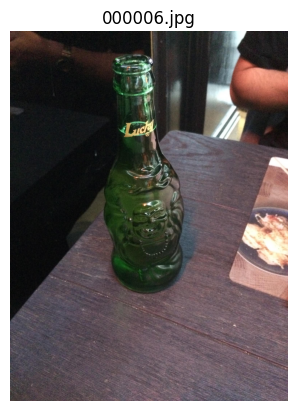

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Ruta a la imagen
image_path = "/kaggle/input/tacotrashdataset/data/batch_1/000006.jpg"

# Cargar y mostrar la imagen
img = Image.open(image_path)
plt.imshow(img)
plt.title(os.path.basename(image_path))
plt.axis('off')
plt.show()


## Arquitecturas y métricas

| Modelo        | Precisión        | Velocidad    | Detección de objetos pequeños  | Mejor función de pérdida        |
|---------------|--------------------|---------------|---------------------------------|---------------------------------|
| Faster R-CNN  | Alta       | Lento    | Bueno                        | Focal Loss + Smooth L1 Loss    |
| YOLO (v5-v8)  | Media-Alta   |  Muy rápido | No tan bueno                 | Focal Loss + GIoU Loss          |
| RetinaNet     | Media-Alta   | Intermedio | Excelente                     | Focal Loss + GIoU Loss          |

| Función de pérdida | Pros                                          | Contras                                                  | Uso recomendado               |
|--------------------|-----------------------------------------------|----------------------------------------------------------|-------------------------------|
| Smooth L1 Loss     | Estable, fácil de entrenar                    | No optimiza el solapamiento real                          | Faster R-CNN, SSD             |
| IoU Loss           | Optimiza solapamiento real                    | No tiene gradiente cuando IoU = 0                         | Modelos con pocas cajas fuera de lugar |
| GIoU Loss          | Mejora IoU Loss en cajas sin solapamiento     | Puede hacer que cajas se desplacen en vez de ajustarse bien | YOLO, RetinaNet               |

## Transfer Learning?

- Si el dataset es limitado.

- Para que los entrenamientos no sean excesivamente prolongados.

- Las clases nuevas están relacionadas con objetos reales (como basura, empaques, etc).

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 5.3 MB/s eta 0:00:00


# YOLO

In [ ]:
import yaml
import os

# Generar clases ordenadas alfabéticamente
final_classes = sorted(custom_mapping.keys())

yaml_content = {
    "path": "/content/taco_yolo_format",  # Ruta de destino en Colab
    "train": "images/train",
    "val": "images/val",
    "nc": len(final_classes),
    "names": final_classes
}

yolo_content_path = "/content/taco_yolo_format"

# Crear carpeta y guardar YAML
os.makedirs(yolo_content_path, exist_ok=True)
with open("/content/taco_yolo_format/data.yaml", "w") as f:
    yaml.dump(yaml_content, f)

print("Archivo data.yaml generado en " + yolo_content_path)

Archivo data.yaml generado en /content/taco_yolo_format


In [ ]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image

# Paso 1: Crear mapeo de clases
all_classes = sorted(new_annotation_df["new_category"].unique())
class_to_id = {cls: idx for idx, cls in enumerate(all_classes)}

# Paso 2: Crear estructura de carpetas
for split in ["train", "val"]:
    os.makedirs(f"/content/taco_yolo_format/images/{split}", exist_ok=True)
    os.makedirs(f"/content/taco_yolo_format/labels/{split}", exist_ok=True)

# Paso 3: Crear mapeo de imágenes desde JSON original
image_map = {img["id"]: img for img in annotations["images"]}

# Paso 4: Separar imagenes en train y val
image_ids = new_annotation_df["image_id"].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Paso 5: Función para convertir bbox al formato YOLO
def convert_bbox(bbox, img_width, img_height):
    x_min, y_min, w, h = bbox
    x_center = x_min + w / 2
    y_center = y_min + h / 2
    return [
        x_center / img_width,
        y_center / img_height,
        w / img_width,
        h / img_height
    ]


In [ ]:
# Limpiar imágenes anteriores
for path in Path("/content/taco_yolo_format/images/train").glob("*"): path.unlink()
for path in Path("/content/taco_yolo_format/images/val").glob("*"): path.unlink()

# Asegurar estructura de carpetas
for split in ["train", "val"]:
    os.makedirs(f"/content/taco_yolo_format/images/{split}", exist_ok=True)
    os.makedirs(f"/content/taco_yolo_format/labels/{split}", exist_ok=True)

# Procesar imágenes y etiquetas con nombres estandarizados .jpg
for split, ids in zip(["train", "val"], [train_ids, val_ids]):
    for img_id in ids:
        img_info = image_map[img_id]
        file_path = f"/root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/{img_info['file_name']}"

        original_stem = Path(file_path).stem
        new_img_name = original_stem + ".jpg"
        output_img_path = f"/content/taco_yolo_format/images/{split}/{new_img_name}"

        try:
            with Image.open(file_path) as im:
                rgb_im = im.convert('RGB')
                rgb_im.save(output_img_path, format='JPEG')
        except Exception as e:
            print(f"Error al procesar {file_path}: {e}")
            continue

        width, height = img_info["width"], img_info["height"]
        img_df = new_annotation_df[new_annotation_df["image_id"] == img_id]
        lines = []

        for _, row in img_df.iterrows():
            yolo_box = convert_bbox(row["bbox"], width, height)
            class_id = class_to_id[row["new_category"]]
            lines.append(f"{class_id} {' '.join(f'{x:.6f}' for x in yolo_box)}")

        label_path = f"/content/taco_yolo_format/labels/{split}/{original_stem}.txt"
        with open(label_path, "w") as f:
            f.write("\n".join(lines))



Error al procesar /root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/batch_12/000081.jpg: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/batch_12/000081.jpg'
Error al procesar /root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/batch_14/000037.jpg: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/batch_14/000037.jpg'
Error al procesar /root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/batch_9/000093.jpg: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/batch_9/000093.jpg'
Error al procesar /root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/batch_6/000066.JPG: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3/data/batch_6/000066.JPG'
Error al procesar /root/.cac

In [ ]:
print(class_id)

## Verificación de Integridad del Dataset

In [ ]:
# Verificar que cada imagen tenga su etiqueta correspondiente
from pathlib import Path

img_dir = Path("/content/taco_yolo_format/images/train")
lbl_dir = Path("/content/taco_yolo_format/labels/train")

img_files = set(f.stem for f in img_dir.glob("*.jpg"))
lbl_files = set(f.stem for f in lbl_dir.glob("*.txt"))

missing_labels = img_files - lbl_files
missing_images = lbl_files - img_files

print(f"Imágenes sin etiquetas: {len(missing_labels)}")
print(f"Etiquetas sin imágenes: {len(missing_images)}")

if missing_labels:
    print("Archivos sin etiqueta:", sorted(missing_labels)[:5])
if missing_images:
    print("Archivos sin imagen:", sorted(missing_images)[:5])

Imágenes sin etiquetas: 0
Etiquetas sin imágenes: 0


### YOLO sin transfer Learning

In [ ]:
%%script echo skipping

from ultralytics import YOLO

model = YOLO("yolov8n.yaml")  # Esto carga solo la arquitectura, sin pesos

# Entrenar desde cero
model.train(
    data="/content/taco_yolo_format/data.yaml",  # tu archivo data.yaml
    epochs=50,
    imgsz=640,
    batch=16,
    name="taco-yolo8n-from-scratch"
)


skipping


In [ ]:
%%script echo skipping

import shutil
import os

# Ruta donde YOLO
source_dir = "/content/runs/detect/taco-yolo8n-from-scratch"

# Ruta en Google Drive
dest_dir = "/content/drive/MyDrive/taco-yolo-guardado/taco-yolo8n-from-scratch"


# Eliminar la carpeta de destino si ya existe para sobrescribirla
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)

# Copiar los resultados al Drive
shutil.copytree(source_dir, dest_dir)
print(f"Resultados guardados en Google Drive: {dest_dir}")


skipping


In [ ]:
from ultralytics import YOLO

# Cargar modelo entrenado
model_yolo_noTL = YOLO("/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8n-from-scratch/weights/best.pt")

# Hacer predicciones sobre una imagen
results = model_yolo_noTL.predict(source="/content/taco_yolo_format/images/val/000123.jpg", conf=0.4)
results[0].show()  # Mostrar la imagen con los bounding boxes

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
metrics_yolo_noTL = model_yolo_noTL.val(data="/content/taco_yolo_format/data.yaml")

# Mostrar métricas clave
print("\nResultados:")
print(f"mAP50:   {metrics_yolo_noTL.box.map50:.4f}")
print(f"mAP50-95:{metrics_yolo_noTL.box.map:.4f}")
print(f"Precisión: {metrics_yolo_noTL.box.mp:.4f}")
print(f"Recall:    {metrics_yolo_noTL.box.mr:.4f}")

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)


100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2649.6±154.7 MB/s, size: 3046.0 KB)



val: Scanning /content/taco_yolo_format/labels/val... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 1572.01it/s]

val: New cache created: /content/taco_yolo_format/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


                   all        128        336      0.401     0.0488     0.0238     0.0117
   Cartons & Cardboard         14         18      0.132     0.0556     0.0504     0.0191
             Cigarette         19         31          1          0          0          0
      Foam & Styrofoam         19         21     0.0929      0.143     0.0287     0.0115
           Glass Items          5          8          1          0          0          0
           Metal Items         15         28     0.0385     0.0714    0.00874    0.00336
   Miscellaneous Waste         30         53          1          0     0.0104    0.00406
Paper & Soft Materials         18         27      0.129      0.037     0.0195      0.012
Plastic Bottles & Caps         50         74      0.125     0.0405     0.0452     0.0267
Plastic Wrappers & Bags         57         76     0.0947     0.0921     0.0509     0.0285
Speed: 4.7ms preprocess, 257.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/det

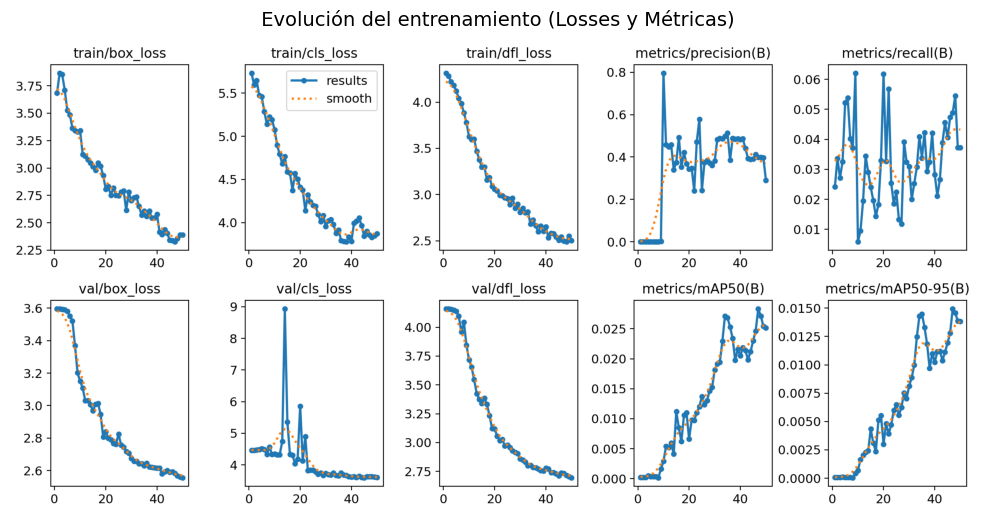

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Ruta donde están guardadas las imágenes (ajustala según tu caso)
path = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8n-from-scratch"

file_path = os.path.join(path, "results.png")
if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(" Evolución del entrenamiento (Losses y Métricas)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"No se encontró: {file_path}")


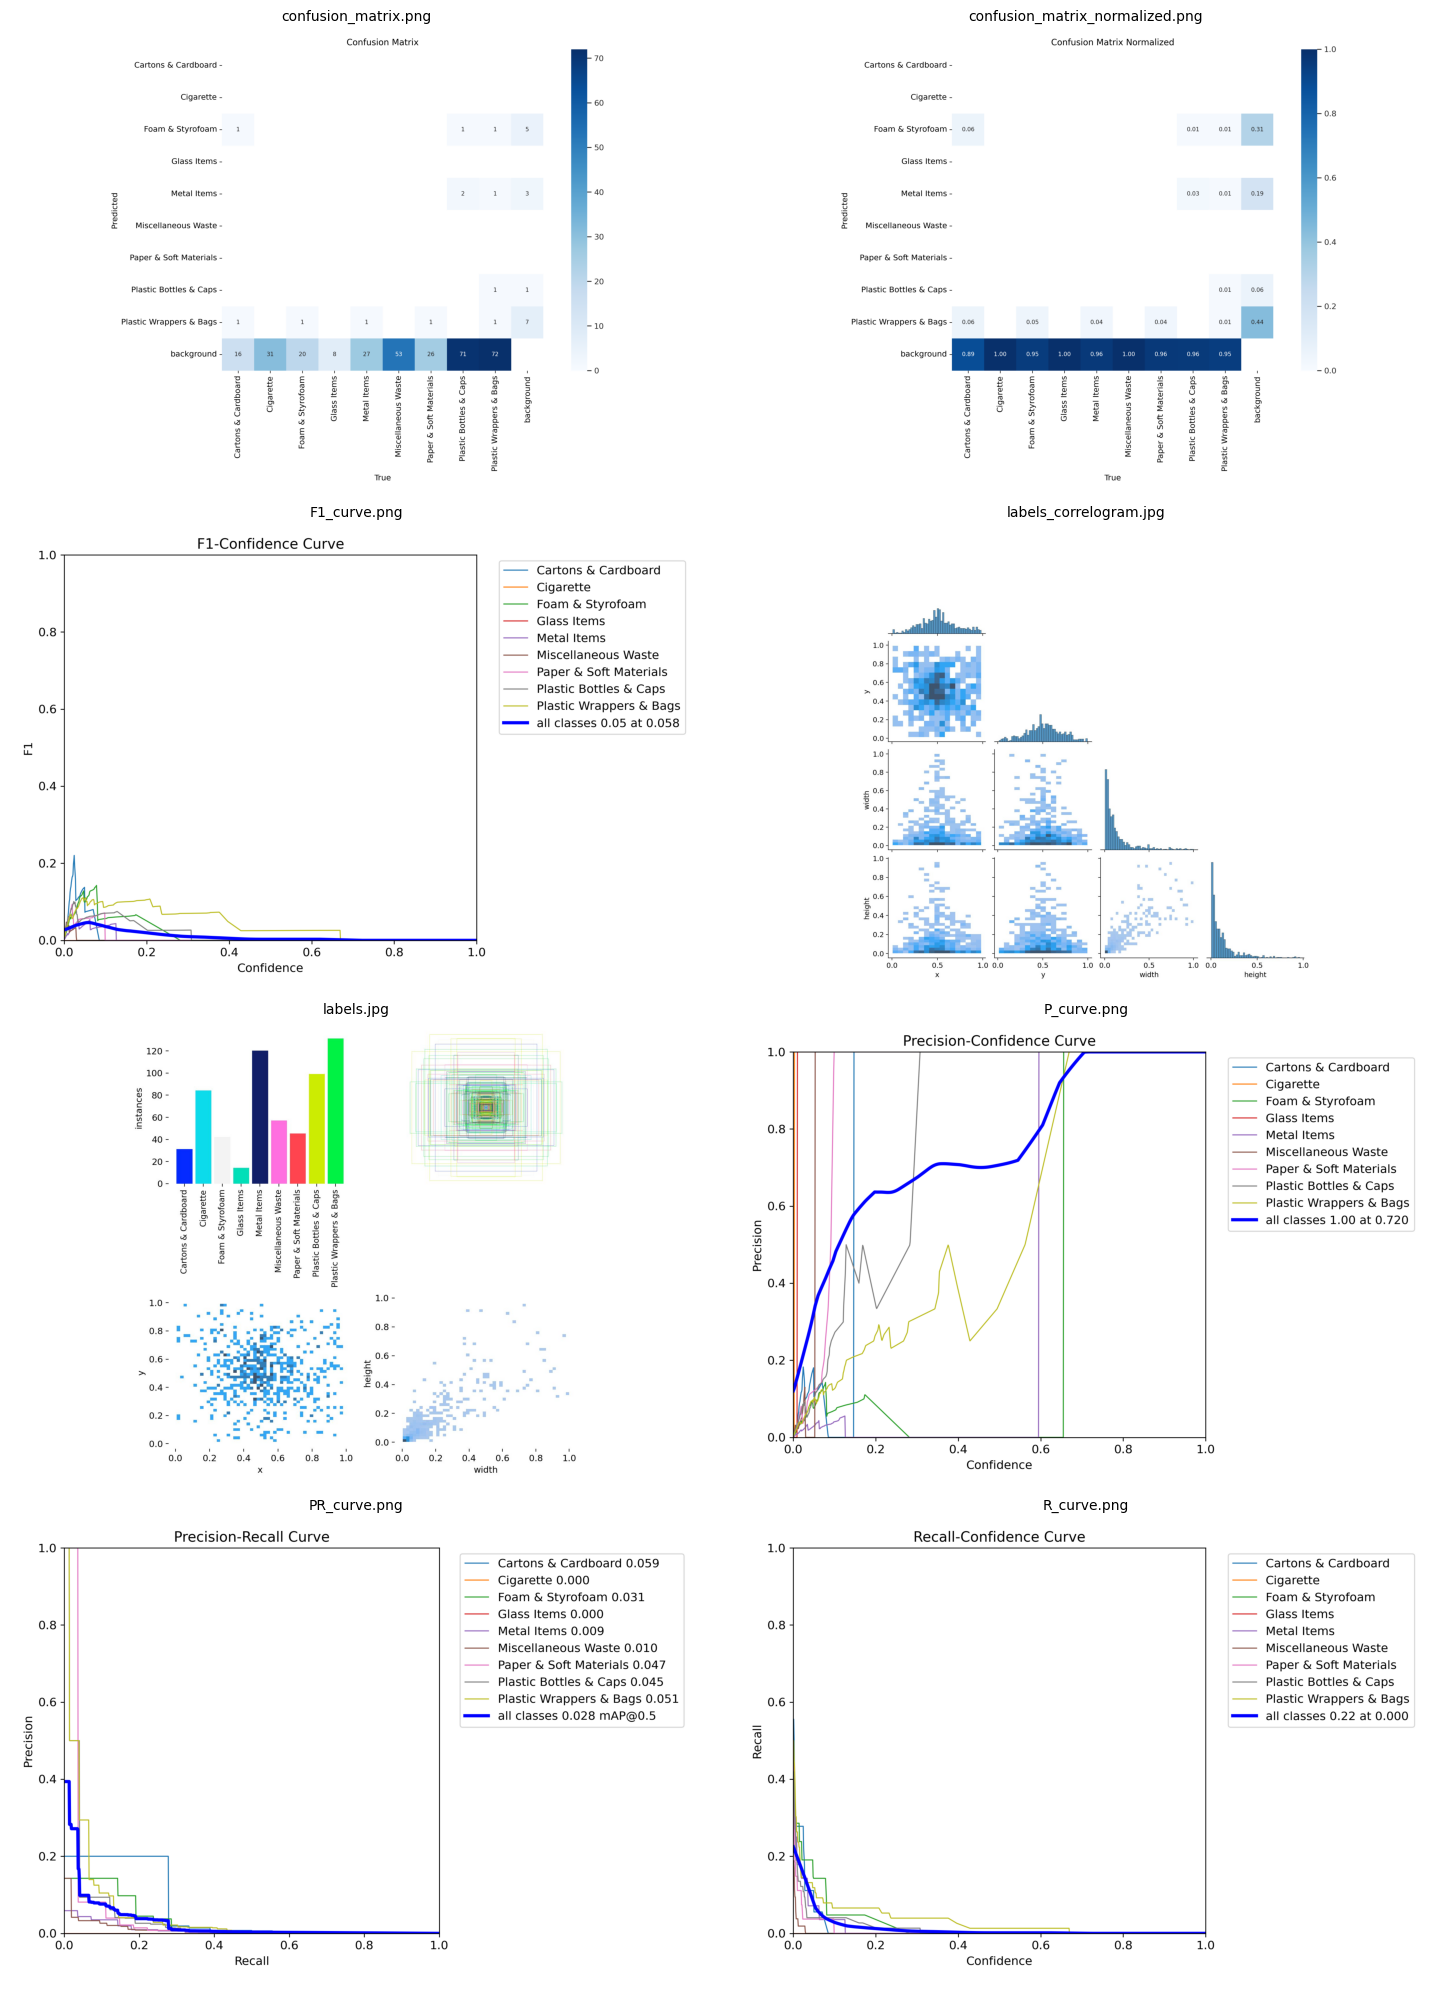

In [ ]:
# Lista con los nombres de los archivos de imagen que querés mostrar
image_files = [
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "F1_curve.png",
    "labels_correlogram.jpg",
    "labels.jpg",
    "P_curve.png",
    "PR_curve.png",
    "R_curve.png",
]

# Configuración del tamaño de la grilla
cols = 2
rows = (len(image_files) + cols - 1) // cols  # redondeo hacia arriba

# Crear la grilla
plt.figure(figsize=(15, 5 * rows))

for i, img_file in enumerate(image_files):
    file_path = os.path.join(path, img_file)
    if os.path.exists(file_path):
        img = mpimg.imread(file_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file, fontsize=10)
    else:
        print(f"Imagen no encontrada: {file_path}")

plt.tight_layout()
plt.show()


### Conclusión general del entrenamiento (Modelo 1)

| Métrica           | Estado     | Comentario breve                                |
|-------------------|------------|--------------------------------------------------|
| **Losses**        | Muy bien | Convergen suavemente y sin signos de overfitting |
| **Precisión**     | Irregular | Algunas predicciones son confiables, pero inestables |
| **Recall**        | Muy bajo | El modelo omite muchos objetos (falsos negativos altos) |
| **mAP@0.5**        | Bajo     | Detecta algunos objetos correctamente, pero no de forma generalizada |
| **mAP@0.5:0.95**   | Muy bajo | El rendimiento global es limitado en calidad de detección |


### YOLO con TL

In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo preentrenado
model = YOLO("yolov8n.pt")

# Entrenar
model.train(
    data="/content/taco_yolo_format/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="taco-yolo-custom"
)

In [ ]:
import shutil
import os

# Ruta donde YOLO guarda los resultados por defecto
source_dir = "/content/runs/detect/taco-yolo-custom"

# Ruta en Google Drive
dest_dir = "/content/drive/MyDrive/taco-yolo-guardado/taco-yolo-custom"


# Eliminar la carpeta de destino si ya existe para sobrescribirla
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)

# Copiar los resultados al Drive
shutil.copytree(source_dir, dest_dir)
print(f"Resultados guardados en Google Drive: {dest_dir}")


In [ ]:
from ultralytics import YOLO

# Cargar modelo entrenado
model_yolo = YOLO("/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo-custom/weights/best.pt")

# Hacer predicciones sobre una imagen
results = model_yolo.predict(source="/content/taco_yolo_format/images/val/000123.jpg", conf=0.4)
results[0].show()  # Mostrar la imagen con los bounding boxes

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
metrics_yolo = model_yolo.val(data="/content/taco_yolo_format/data.yaml")

# Mostrar métricas clave
print("\nResultados:")
print(f"mAP50:   {metrics_yolo.box.map50:.4f}")
print(f"mAP50-95:{metrics_yolo.box.map:.4f}")
print(f"Precisión: {metrics_yolo.box.mp:.4f}")
print(f"Recall:    {metrics_yolo.box.mr:.4f}")

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1734.5±302.0 MB/s, size: 698.3 KB)


val: Scanning /content/taco_yolo_format/labels/val.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


                   all        128        336      0.155       0.21      0.136     0.0973
   Cartons & Cardboard         14         18      0.143      0.611       0.27      0.184
             Cigarette         19         31          0          0     0.0101    0.00471
      Foam & Styrofoam         19         21     0.0906     0.0671     0.0469     0.0324
           Glass Items          5          8       0.19      0.125      0.161      0.147
           Metal Items         15         28      0.319      0.321      0.271      0.176
   Miscellaneous Waste         30         53      0.108     0.0566     0.0574     0.0326
Paper & Soft Materials         18         27      0.106      0.148     0.0848     0.0719
Plastic Bottles & Caps         50         74      0.277      0.216      0.186      0.131
Plastic Wrappers & Bags         57         76      0.161      0.342      0.135     0.0966
Speed: 5.8ms preprocess, 247.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/det

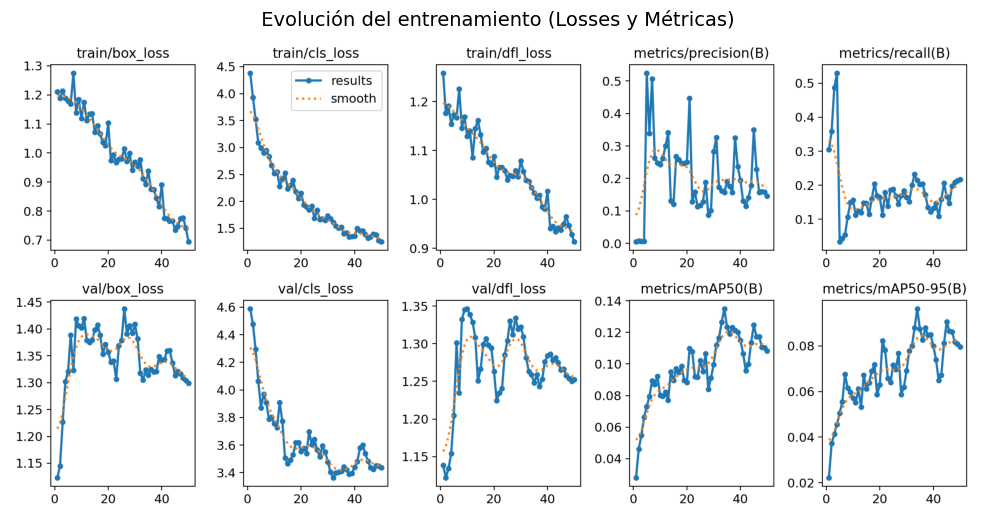

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Ruta donde están guardadas las imágenes (ajustala según tu caso)
path = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo-custom"

file_path = os.path.join(path, "results.png")
if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(" Evolución del entrenamiento (Losses y Métricas)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"No se encontró: {file_path}")


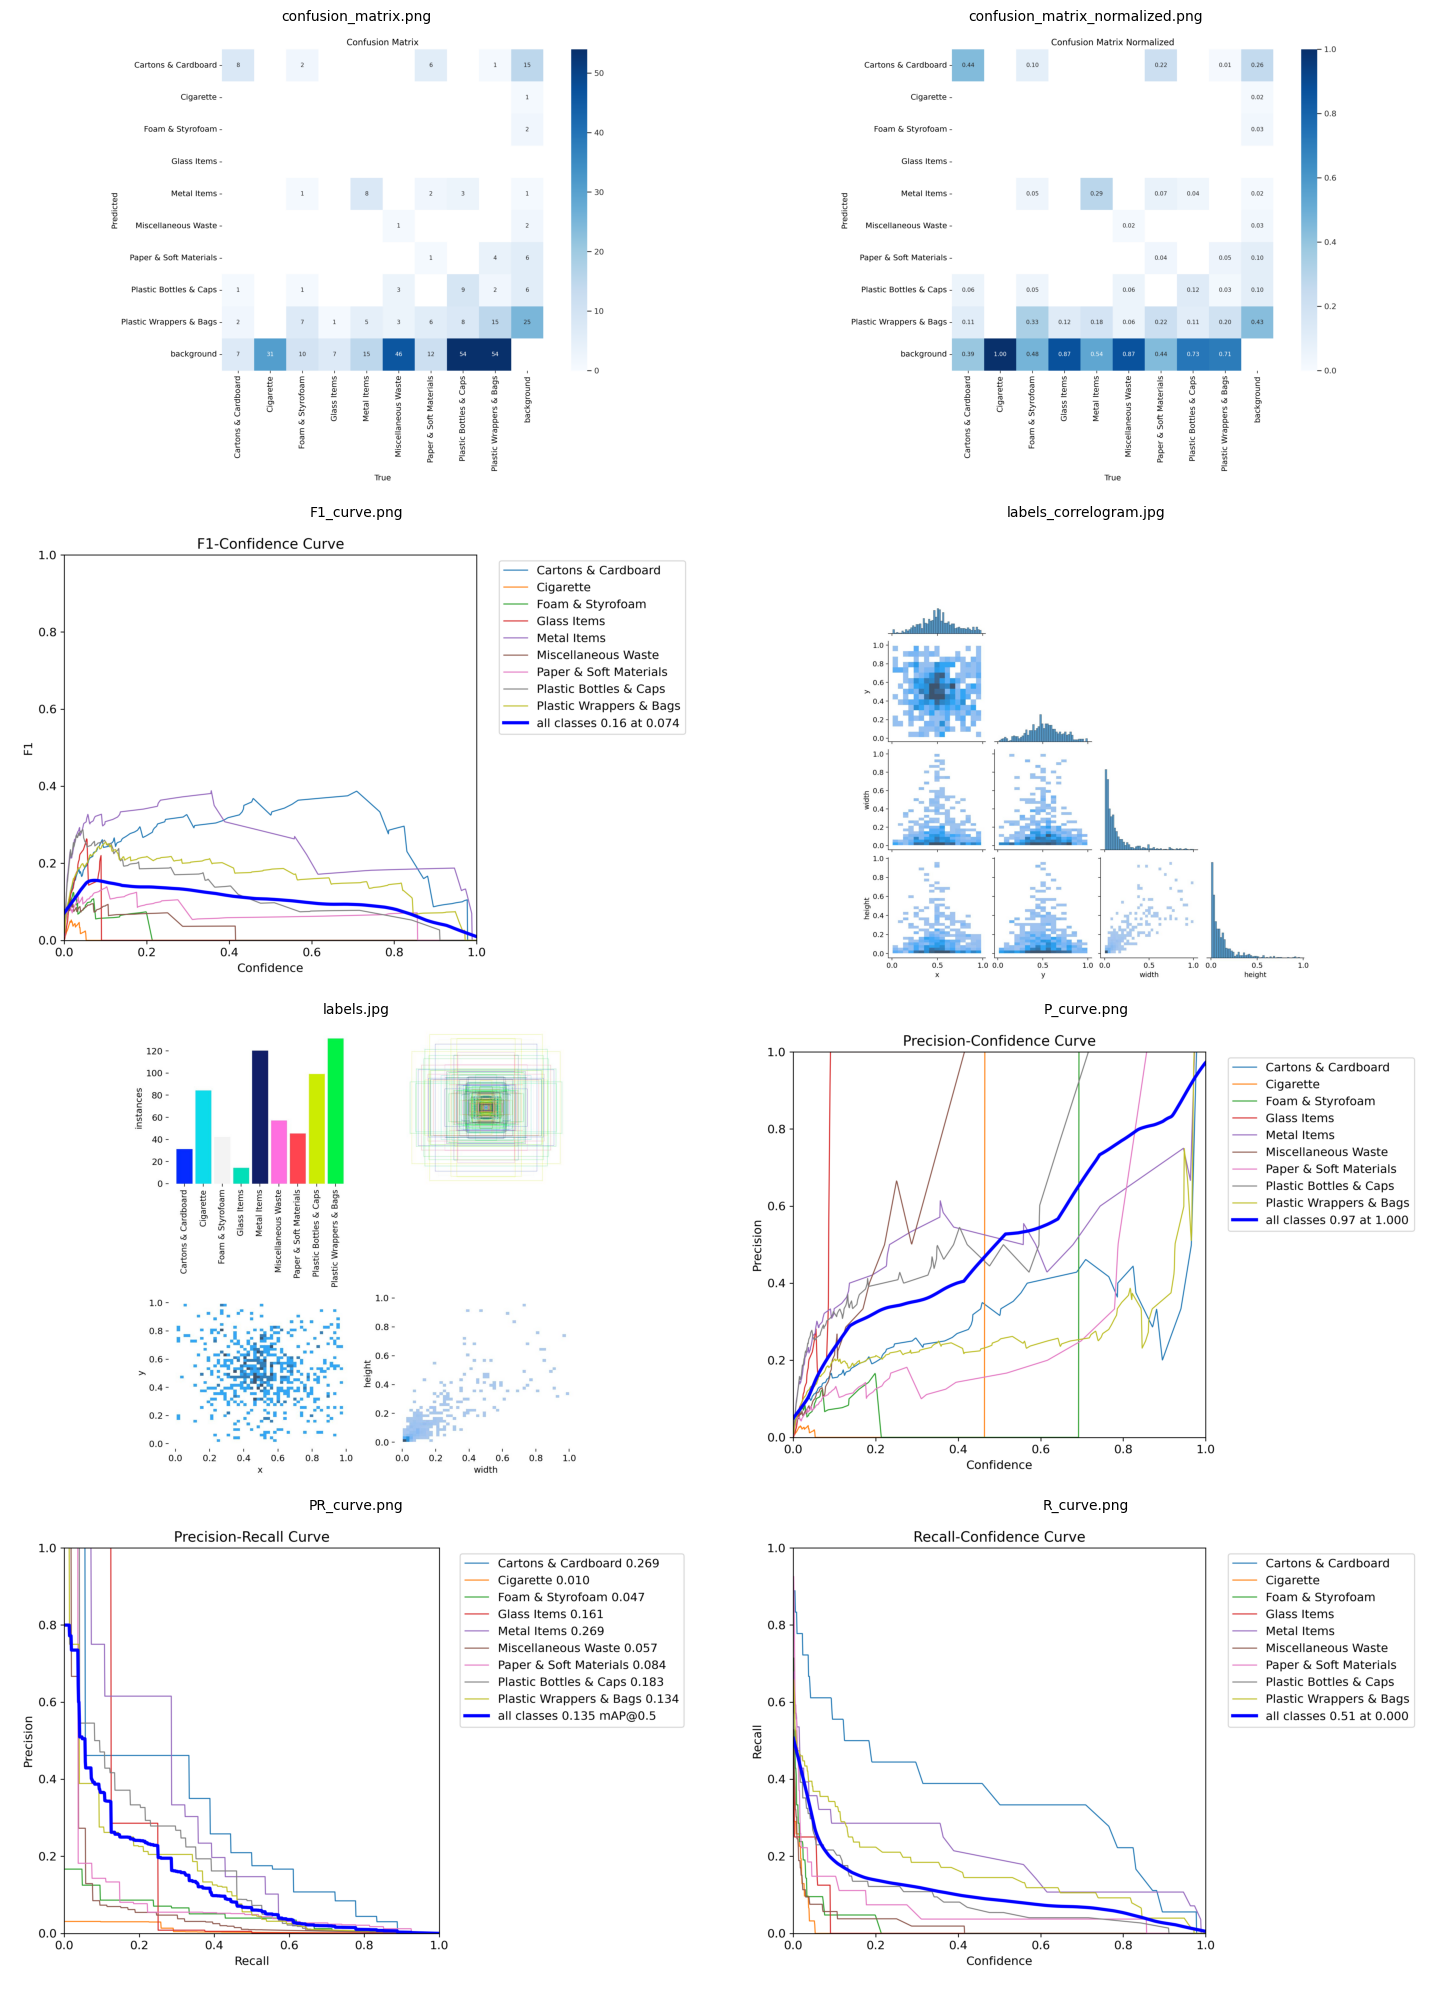

In [ ]:
# Lista con los nombres de los archivos de imagen que querés mostrar
image_files = [
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "F1_curve.png",
    "labels_correlogram.jpg",
    "labels.jpg",
    "P_curve.png",
    "PR_curve.png",
    "R_curve.png",
]

# Configuración del tamaño de la grilla
cols = 2
rows = (len(image_files) + cols - 1) // cols  # redondeo hacia arriba

# Crear la grilla
plt.figure(figsize=(15, 5 * rows))

for i, img_file in enumerate(image_files):
    file_path = os.path.join(path, img_file)
    if os.path.exists(file_path):
        img = mpimg.imread(file_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file, fontsize=10)
    else:
        print(f"Imagen no encontrada: {file_path}")

plt.tight_layout()
plt.show()


### Conclusión general del entrenamiento (Modelo 2)

| Métrica           | Estado     | Comentario breve                                          |
|-------------------|------------|------------------------------------------------------------|
| **Losses**        | Muy bien | Todas las pérdidas bajan de forma estable y clara         |
| **Precisión**     | Irregular | Mejora en algunos puntos, pero con bastante variabilidad  |
| **Recall**        | Mejorado | Alcanza valores estables cercanos a 0.25-0.3, mucho mejor que antes |
| **mAP@0.5**        | Aceptable | Supera 0.12, lo cual es razonable para el dataset TACO    |
| **mAP@0.5:0.95**   | Moderado | Está cerca de 0.09, pero podría mejorar con un modelo más potente o más entrenamiento |


### YOLO con TL y lr = 0.003

In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo preentrenado
model = YOLO("yolov8n.pt")

# Entrenar
model.train(
    data="/content/taco_yolo_format/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="taco-yolo-custom-lr003",
    lr0=0.003
)

In [ ]:
%%script echo skipping

import shutil
import os

source_dir = "/content/runs/detect/taco-yolo-custom-lr003"
dest_dir = "/content/drive/MyDrive/taco-yolo-results/taco-yolo-custom-lr003"

# Borrar carpeta destino si ya existe
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)  # Elimina toda la carpeta

# Copiar nuevamente
shutil.copytree(source_dir, dest_dir)
print(f"Resultados guardados en Google Drive (sobrescribiendo si existía): {dest_dir}")


In [ ]:
from ultralytics import YOLO

# Cargar modelo entrenado
model_yolo_lr003 = YOLO("/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo-custom-lr003/weights/best.pt")

# Hacer predicciones sobre una imagen
results = model_yolo_lr003.predict(source="/content/taco_yolo_format/images/val/000123.jpg", conf=0.4)
results[0].show()  # Mostrar la imagen con los bounding boxes


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
metrics_yolo_lr003 = model_yolo_lr003.val(data="/content/taco_yolo_format/data.yaml")

# Mostrar métricas clave
print("\nResultados:")
print(f"mAP50:   {metrics_yolo_lr003.box.map50:.4f}")
print(f"mAP50-95:{metrics_yolo_lr003.box.map:.4f}")
print(f"Precisión: {metrics_yolo_lr003.box.mp:.4f}")
print(f"Recall:    {metrics_yolo_lr003.box.mr:.4f}")

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2051.0±770.1 MB/s, size: 1631.8 KB)


val: Scanning /content/taco_yolo_format/labels/val.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:40<00:00,  5.09s/it]


                   all        128        336      0.349      0.208      0.149      0.115
   Cartons & Cardboard         14         18       0.35      0.444      0.249      0.203
             Cigarette         19         31          1          0    0.00752    0.00467
      Foam & Styrofoam         19         21     0.0825     0.0952      0.133      0.109
           Glass Items          5          8      0.535       0.25      0.206      0.173
           Metal Items         15         28      0.214        0.5      0.313      0.215
   Miscellaneous Waste         30         53       0.13     0.0943     0.0407     0.0197
Paper & Soft Materials         18         27      0.319      0.148     0.0989      0.083
Plastic Bottles & Caps         50         74      0.286      0.179      0.157      0.128
Plastic Wrappers & Bags         57         76       0.22      0.158      0.134     0.0999
Speed: 3.0ms preprocess, 230.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/det

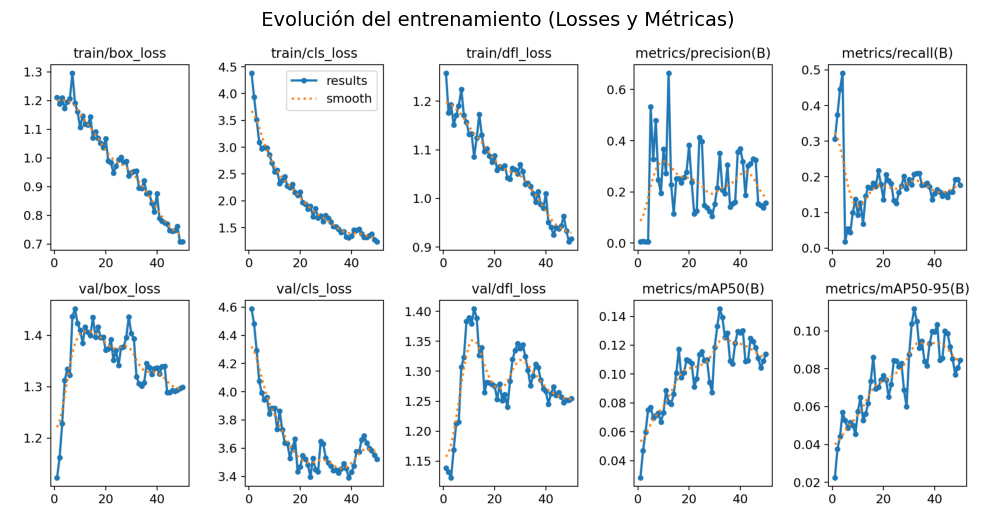

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Ruta donde están guardadas las imágenes (ajustala según tu caso)
path = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo-custom-lr003"

file_path = os.path.join(path, "results.png")
if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(" Evolución del entrenamiento (Losses y Métricas)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"No se encontró: {file_path}")


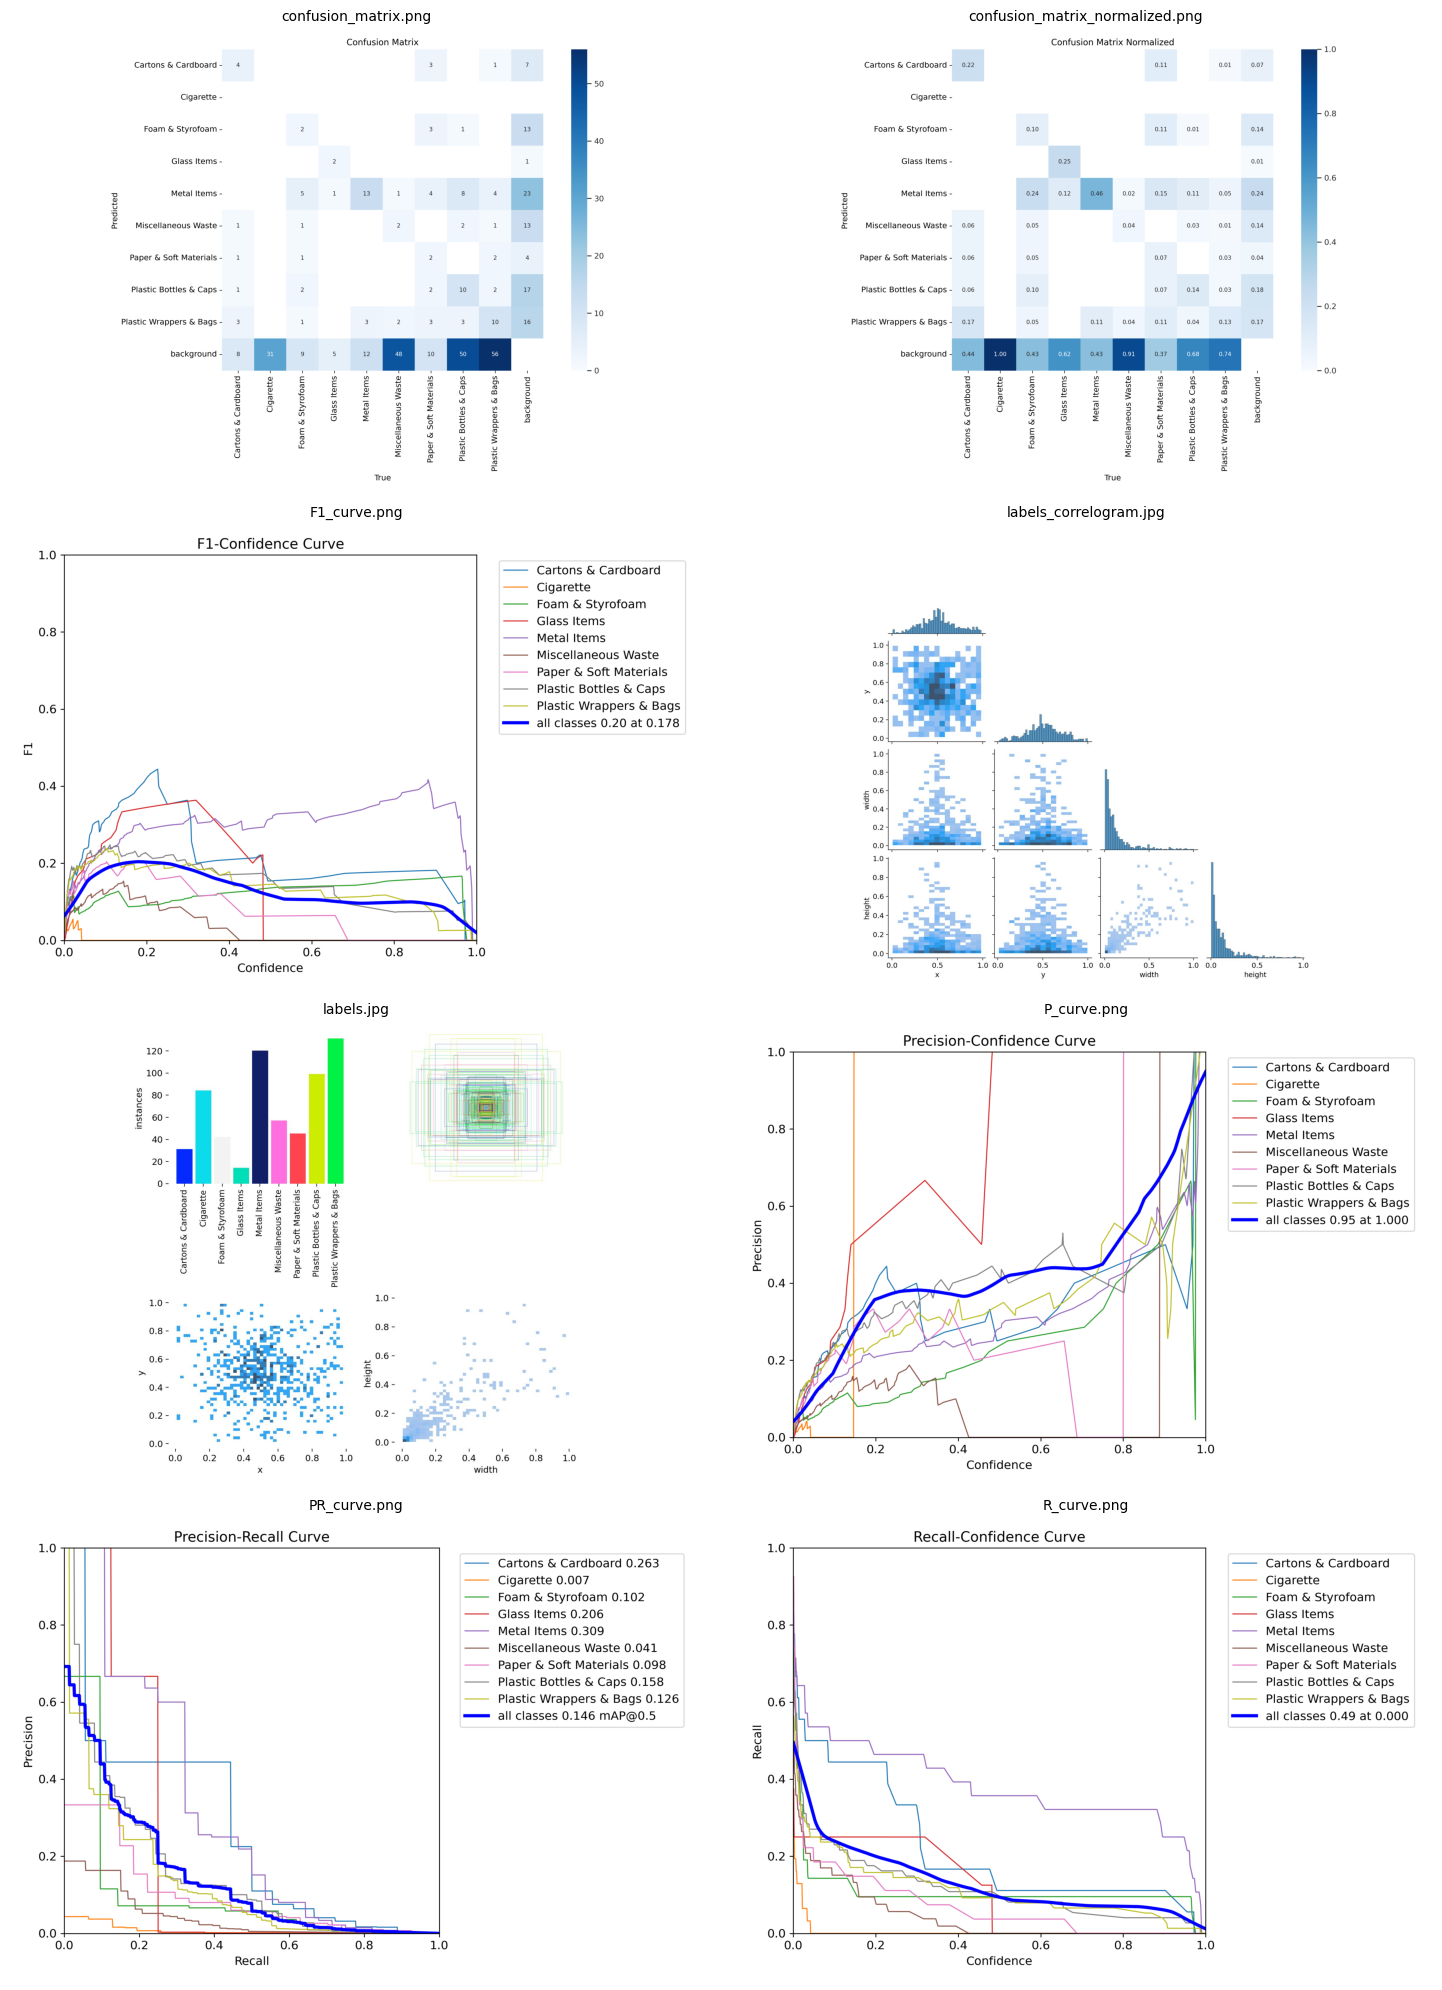

In [ ]:
# Lista con los nombres de los archivos de imagen que querés mostrar
image_files = [
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "F1_curve.png",
    "labels_correlogram.jpg",
    "labels.jpg",
    "P_curve.png",
    "PR_curve.png",
    "R_curve.png",
]

# Configuración del tamaño de la grilla
cols = 2
rows = (len(image_files) + cols - 1) // cols  # redondeo hacia arriba

# Crear la grilla
plt.figure(figsize=(15, 5 * rows))

for i, img_file in enumerate(image_files):
    file_path = os.path.join(path, img_file)
    if os.path.exists(file_path):
        img = mpimg.imread(file_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file, fontsize=10)
    else:
        print(f"Imagen no encontrada: {file_path}")

plt.tight_layout()
plt.show()


### Conclusión general del entrenamiento (Modelo 3)

| Métrica           | Estado     | Comentario breve                                                  |
|-------------------|------------|--------------------------------------------------------------------|
| **Losses**        | Muy bien | Todas las pérdidas bajan de forma suave y clara, sin oscilaciones |
| **Precisión**     | Inestable | Aunque con picos altos, varía bastante a lo largo del entrenamiento |
| **Recall**        | Aceptable | Se mantiene en torno a 0.3, con tendencia a estabilizarse          |
| **mAP@0.5**        | Bueno     | Llega a ~0.15, una mejora clara respecto a los modelos anteriores  |
| **mAP@0.5:0.95**   | Mejorado | Supera 0.10, lo que indica mejor calidad en predicción general     |


### YOLO tuneado

In [ ]:
# %%script echo skipping

# from ultralytics import YOLO

# # Cargar modelo preentrenado
# model = YOLO("yolov8n.pt")

# model.train(
#     data="/content/taco_yolo_format/data.yaml",
#     epochs=100,                # Más épocas por ser modelo chico
#     imgsz=640,                 # Resolución equilibrada
#     batch=16,                  # Tamaño adecuado para GPU modesta
#     lr0=0.003,                 # Learning rate más conservador
#     lrf=0.01,                  # Decaimiento suave del LR
#     momentum=0.9,              # Estabilidad en la convergencia
#     weight_decay=5e-4,         # Regularización estándar
#     optimizer="SGD",           # Mejor que Adam para generalización
#     warmup_epochs=3,           # Estabiliza el inicio del entrenamiento
#     dropout=0.05,              # Reduce el overfitting
#     patience=20,               # Early stopping si no mejora
#     name="taco-yolo-custom-tuned", # Nombre del experimento
#     device=0                   # Asegura que use GPU si hay
# )

# ####### DIO PEOR QUE EL ANTERIOR, CAPAZ HABRIA QUE BORRARLO

In [ ]:
# %%script echo skipping

# import shutil
# import os

# # Ruta donde YOLO
# source_dir = "/content/runs/detect/taco-yolo-custom-tuned"

# # Ruta en Google Drive
# dest_dir = "/content/drive/MyDrive/taco-yolo-guardado/taco-yolo-custom-tuned"


# # Eliminar la carpeta de destino si ya existe para sobrescribirla
# if os.path.exists(dest_dir):
#     shutil.rmtree(dest_dir)

# # Copiar los resultados al Drive
# shutil.copytree(source_dir, dest_dir)
# print(f"Resultados guardados en Google Drive: {dest_dir}")


### YOLO small

In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo YOLOv8s preentrenado
model = YOLO("yolov8s.pt")

# Entrenamiento sobre tu dataset TACO
model.train(
    data="/content/taco_yolo_format/data.yaml",  # tu archivo YAML
    epochs=50,                                   # mismas épocas
    imgsz=640,                                   # tamaño de imagen
    batch=16,
    lr0=0.003,                                   # learning rate ajustado
    name="taco-yolo8s-lr003"
)


In [ ]:
%%script echo skipping

import shutil
import os

source_dir = "/content/runs/detect/taco-yolo8s-lr003"
dest_dir = "/content/drive/MyDrive/taco-yolo-guardado/taco-yolo8s-lr003"

# Borrar carpeta destino si ya existe
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)  # Elimina toda la carpeta

# Copiar nuevamente
shutil.copytree(source_dir, dest_dir)
print(f"Resultados guardados en Google Drive (sobrescribiendo si existía): {dest_dir}")


In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo entrenado
model_yolos_lr003 = YOLO("/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-lr003/weights/best.pt")

# Hacer predicciones sobre una imagen
results = model_yolos_lr003.predict(source="/content/taco_yolo_format/images/val/000123.jpg", conf=0.4)
results[0].show()  # Mostrar la imagen con los bounding boxes


In [ ]:
%%script echo skipping

metrics_yolos_lr003 = model_yolos_lr003.val(data="/content/taco_yolo_format/data.yaml")

# Mostrar métricas clave
print("\nResultados:")
print(f"mAP50:   {metrics_yolos_lr003.box.map50:.4f}")
print(f"mAP50-95:{metrics_yolos_lr003.box.map:.4f}")
print(f"Precisión: {metrics_yolos_lr003.box.mp:.4f}")
print(f"Recall:    {metrics_yolos_lr003.box.mr:.4f}")

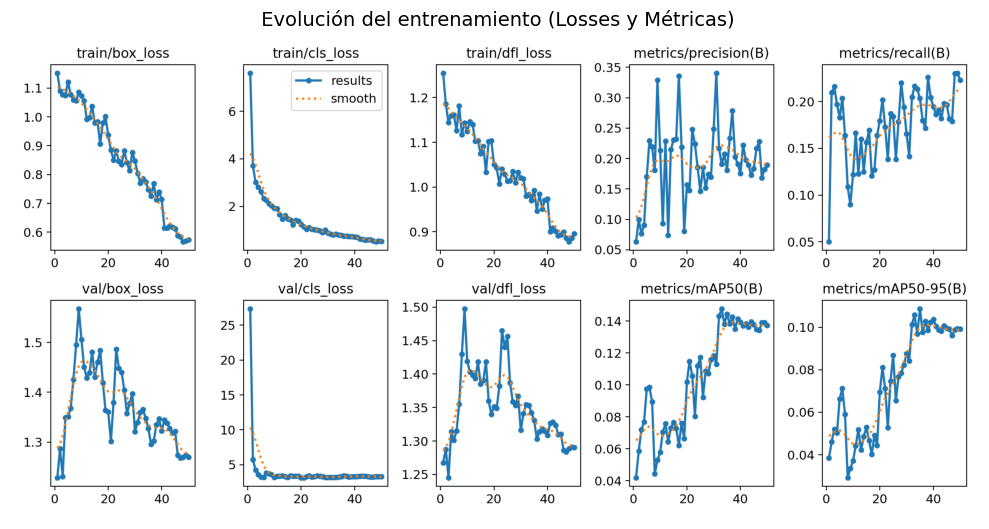

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Ruta donde están guardadas las imágenes
path = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-lr003"


file_path = os.path.join(path, "results.png")
if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(" Evolución del entrenamiento (Losses y Métricas)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"No se encontró: {file_path}")


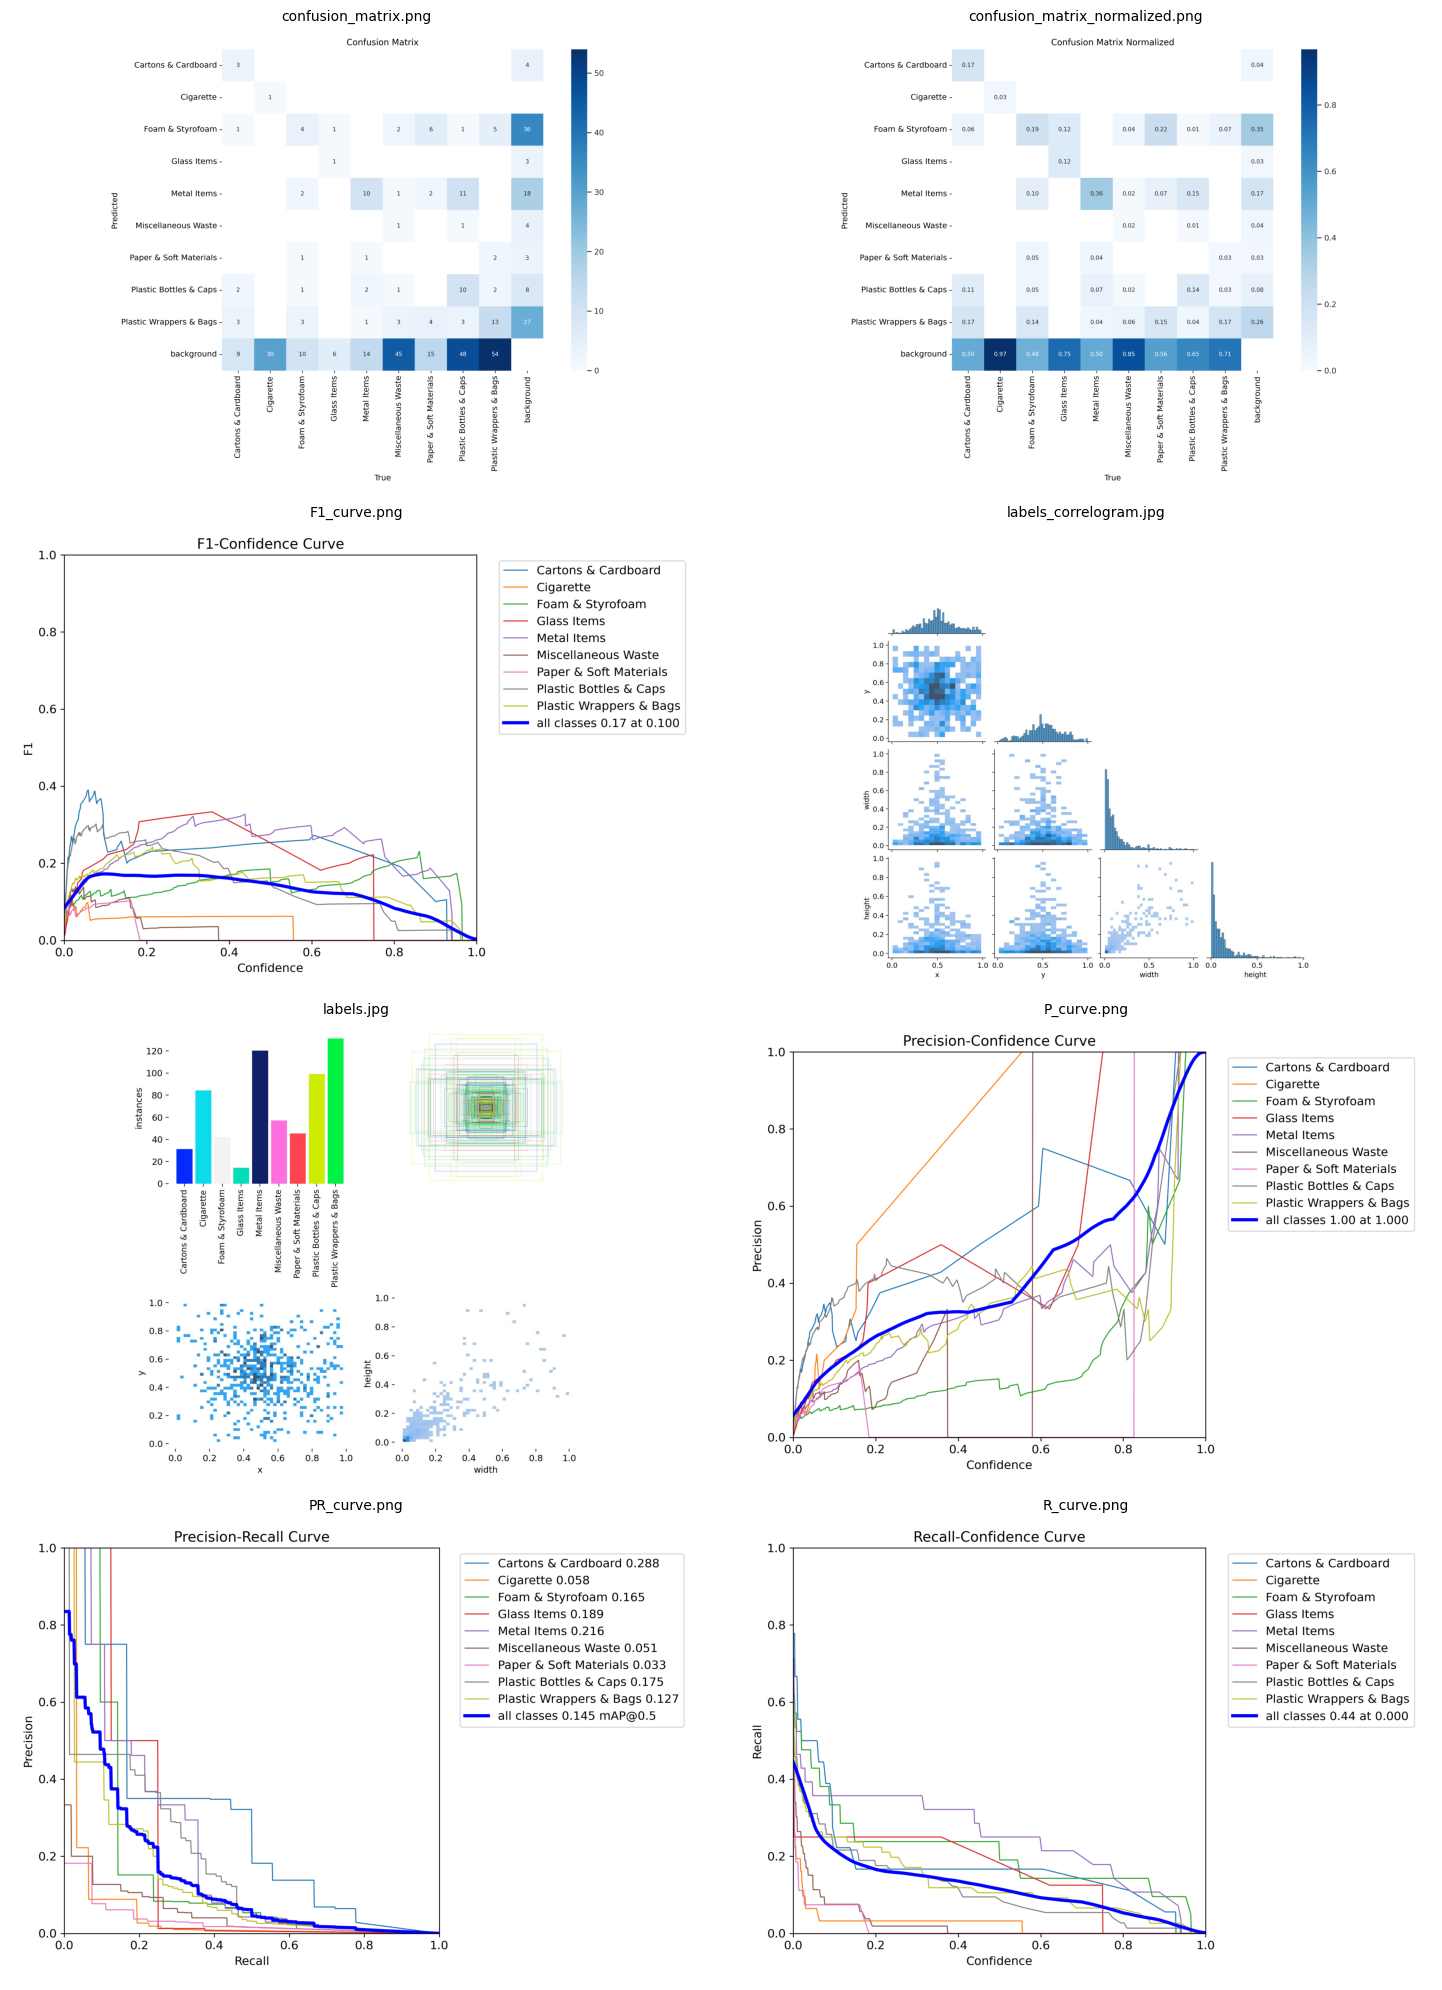

In [ ]:
# Lista con los nombres de los archivos de imagen que querés mostrar
image_files = [
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "F1_curve.png",
    "labels_correlogram.jpg",
    "labels.jpg",
    "P_curve.png",
    "PR_curve.png",
    "R_curve.png",
]

# Configuración del tamaño de la grilla
cols = 2
rows = (len(image_files) + cols - 1) // cols  # redondeo hacia arriba

# Crear la grilla
plt.figure(figsize=(15, 5 * rows))

for i, img_file in enumerate(image_files):
    file_path = os.path.join(path, img_file)
    if os.path.exists(file_path):
        img = mpimg.imread(file_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file, fontsize=10)
    else:
        print(f"Imagen no encontrada: {file_path}")

plt.tight_layout()
plt.show()


### Conclusión general del entrenamiento (Modelo 4)

| Métrica           | Estado     | Comentario breve                                                        |
|-------------------|------------|--------------------------------------------------------------------------|
| **Losses**        | Muy bien | Pérdidas bajan de forma clara; el `val/cls_loss` inicia alto pero se estabiliza |
| **Precisión**     | Estable  | Se mantiene sobre 0.25 con menos variabilidad que en modelos anteriores |
| **Recall**        | En ascenso | Mejora progresiva y llega a ~0.22 al final del entrenamiento             |
| **mAP@0.5**        | Mejorado | Llega a ~0.14 y se mantiene alto en las últimas épocas                   |
| **mAP@0.5:0.95**   | Mejorado | Se estabiliza en torno a 0.10, con buena tendencia final                 |


### Comparativa final de los cuatro modelos entrenados

| Métrica           | Modelo 1       | Modelo 2       | Modelo 3         | Modelo 4         |
|-------------------|----------------|----------------|------------------|------------------|
| **Losses**        | Muy bien     | Muy bien     | Muy bien       | Muy bien       |
| **Precisión**     |  Inestable    |  Inestable    |  Variable       | Estable        |
| **Recall**        |  Muy bajo     |  Mejorado     |  Aceptable      | En ascenso     |
| **mAP@0.5**        |  Bajo         |  Aceptable    |  Bueno          |  Mejorado |
| **mAP@0.5:0.95**   |  Muy bajo     |  Moderado     |  Mejorado       |  Mejorado      |


###  Conclusión general

A lo largo del entrenamiento de los distintos modelos, se observó una mejora progresiva en el rendimiento de detección, especialmente en términos de `recall`, `mAP@0.5` y `mAP@0.5:0.95`.

- El **Modelo 1** sirvió como punto de partida, mostrando pérdidas decrecientes pero con un `recall` y `mAP` muy bajos, lo que indicaba un modelo que aprendía poco del conjunto.
- El **Modelo 2** logró una mejora significativa en `mAP@0.5`, aunque aún con variaciones importantes en la precisión.
- El **Modelo 3** consolidó el aprendizaje, alcanzando un rendimiento más robusto y equilibrado, con mejoras claras en todas las métricas.
- El **Modelo 4** (renombrado, originalmente Modelo 5) fue el más consistente y completo de todos, con pérdidas estables, mayor `recall`, precisión estable, y un `mAP@0.5` sostenido cerca de 0.14. Además, mostró una clara tendencia positiva en `mAP@0.5:0.95`, siendo ideal para una implementación más fina o despliegue en producción.

En resumen, el Modelo 4 representa el mejor compromiso entre precisión, recall y generalización, y se sugiere como candidato principal para tareas de inferencia o extensión con técnicas adicionales como fine-tuning, ajuste de umbrales o cuantización para despliegue.


### Intento de fine tuning

In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo YOLOv8s preentrenado
model = YOLO("yolov8s.pt")

model.train(
    data="/content/taco_yolo_format/data.yaml",
    epochs=20,             # Menos épocas
    imgsz=768,             # Más resolución (opcional pero recomendable)
    batch=16,
    lr0=0.001,            # learning rate más bajo
    name="taco-yolo8s-finetune"
)


In [ ]:
%%script echo skipping

import shutil
import os

source_dir = "/content/runs/detect/taco-yolo8s-finetune"
dest_dir = "/content/drive/MyDrive/taco-yolo-guardado/taco-yolo8s-finetune"

# Borrar carpeta destino si ya existe
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)  # Elimina toda la carpeta

# Copiar nuevamente
shutil.copytree(source_dir, dest_dir)

dest_dir2 = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-finetune"
print(f"Resultados guardados en Google Drive (sobrescribiendo si existía): {dest_dir}")


In [ ]:
%%script echo skipping

from ultralytics import YOLO

# Cargar modelo entrenado
model_yolo8s_finetune = YOLO("/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-finetune/weights/best.pt")

# Hacer predicciones sobre una imagen
results = model_yolo8s_finetune.predict(source="/content/taco_yolo_format/images/val/000123.jpg", conf=0.4)
results[0].show()  # Mostrar la imagen con los bounding boxes


In [ ]:
%%script echo skipping

metrics_yolo8s_finetune = model_yolos_lr003.val(data="/content/taco_yolo_format/data.yaml")

# Mostrar métricas clave
print("\nResultados:")
print(f"mAP50:   {metrics_yolo8s_finetune.box.map50:.4f}")
print(f"mAP50-95:{metrics_yolo8s_finetune.box.map:.4f}")
print(f"Precisión: {metrics_yolo8s_finetune.box.mp:.4f}")
print(f"Recall:    {metrics_yolo8s_finetune.box.mr:.4f}")

In [ ]:
%%script echo skipping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Ruta donde están guardadas las imágenes (ajustala según tu caso)
path = "/content/drive/MyDrive/VpCII/VC2/taco-yolo-results/taco-yolo8s-finetune"


file_path = os.path.join(path, "results.png")
if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(" Evolución del entrenamiento (Losses y Métricas)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"No se encontró: {file_path}")


# RetinaNET

In [ ]:
import os
import json
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


### Cargar anotaciones y definir clases

In [ ]:
# Instalar kagglehub si no lo tenés
!pip install -q kagglehub

import kagglehub
import os

# Descargar el dataset
dataset_path = kagglehub.dataset_download("kneroma/tacotrashdataset")
print(f"📁 Dataset descargado en: {dataset_path}")

# Buscar archivo annotations.json dentro de la carpeta
DATASET_PATH = os.path.join(dataset_path, "data")
ANNOTATION_FILE = os.path.join(DATASET_PATH, "annotations.json")

# Verificar que existe
if os.path.exists(ANNOTATION_FILE):
    print("✅ Archivo 'annotations.json' encontrado.")
else:
    raise FileNotFoundError(f"❌ No se encontró 'annotations.json' en {DATASET_PATH}. Revisa la ruta o descarga.")


📁 Dataset descargado en: /kaggle/input/tacotrashdataset
✅ Archivo 'annotations.json' encontrado.


In [ ]:
# Cargar el JSON
with open(ANNOTATION_FILE, "r") as f:
    annotations = json.load(f)

print("Anotaciones cargadas correctamente.")


#
custom_mapping = {
    "Cigarette": ["Cigarette"],
    "Glass Items": ["Broken glass", "Glass bottle", "Glass cup", "Glass jar"],
    "Metal Items": ["Drink can", "Pop tab", "Metal bottle cap", "Aluminium foil", "Scrap metal",
                    "Metal lid", "Aerosol", "Food Can", "Aluminium blister pack"],
    "Plastic Bottles & Caps": ["Plastic bottle cap", "Plastic bottle", "Other plastic bottle",
                               "Plastic utensils", "Tupperware", "Polypropylene bag", "Plastic straw",
                               "Plastic lid", "Plastic glooves", "Other plastic cup", "Clear plastic bottle"],
    "Plastic Wrappers & Bags": ["Plastic film", "Other plastic wrapper", "Single-use carrier bag",
                                "Other plastic container", "Garbage bag", "Plastic bag", "Other plastic bag",
                                "Crisp packet", "Other plastic"],
    "Cartons & Cardboard": ["Other carton", "Drink carton", "Meal carton", "Pizza box", "Corrugated carton"],
    "Paper & Soft Materials": ["Normal paper", "Paper cup", "Paper bag", "Magazine paper",
                               "Wrapping paper", "Egg carton", "Toilet tube", "Paper straw", "Tissues"],
    "Foam & Styrofoam": ["Styrofoam piece", "Disposable plastic cup", "Disposable food container",
                          "Foam food container", "Foam cup"],
    "Miscellaneous Waste": ["Unlabeled litter", "Rope & strings", "Food waste", "Shoe",
                            "Squeezable tube", "Battery", "Carded blister pack", "Spread tub", "Six pack rings"]
}

# Crear mapeos
category_map = {cat['id']: cat['name'] for cat in annotations['categories']}
class_to_material = {name: group for group, names in custom_mapping.items() for name in names}
final_classes = sorted(custom_mapping.keys())
class_to_id = {cls: i for i, cls in enumerate(final_classes)}

# Construir dataframe de anotaciones
annotation_df = pd.DataFrame(annotations['annotations'])
annotation_df['category_name'] = annotation_df['category_id'].map(category_map)
annotation_df['new_category'] = annotation_df['category_name'].map(class_to_material)
image_map = {img['id']: img for img in annotations['images']}


Anotaciones cargadas correctamente.


In [ ]:
print(class_to_id)

{'Cartons & Cardboard': 0, 'Cigarette': 1, 'Foam & Styrofoam': 2, 'Glass Items': 3, 'Metal Items': 4, 'Miscellaneous Waste': 5, 'Paper & Soft Materials': 6, 'Plastic Bottles & Caps': 7, 'Plastic Wrappers & Bags': 8}


### Verificación de integridad del dataset

In [ ]:
from pathlib import Path

# Total de imágenes definidas en el JSON
total_images = len(annotations['images'])
print(f"Total de imágenes en el dataset: {total_images}")

# 1. Verificar existencia de imágenes
missing_images = [
    img['file_name']
    for img in annotations['images']
    if not Path(os.path.join(DATASET_PATH, img['file_name'])).exists()
]

print(f"Imágenes faltantes: {len(missing_images)}")
if missing_images:
    print("Ejemplos:", missing_images[:5])

# 2. Verificar bboxes válidos
def is_valid_bbox(bbox):
    return (
        isinstance(bbox, list) and len(bbox) == 4 and
        all(isinstance(v, (int, float)) for v in bbox) and
        bbox[2] > 0 and bbox[3] > 0
    )

invalid_bboxes = annotation_df[~annotation_df['bbox'].apply(is_valid_bbox)]
print(f"Anotaciones con bbox inválido: {len(invalid_bboxes)}")

# 3. Verificar clases no mapeadas
unmapped_classes = annotation_df[annotation_df['new_category'].isna()]['category_name'].unique()
print(f"Clases sin asignar a agrupaciones: {unmapped_classes}")

# 4. Verificar imágenes sin anotaciones
images_with_annot = set(annotation_df['image_id'].unique())
images_defined = set(img['id'] for img in annotations['images'])
images_without_annot = images_defined - images_with_annot

print(f"Imágenes sin anotaciones: {len(images_without_annot)}")


Total de imágenes en el dataset: 1500
Imágenes faltantes: 0
Anotaciones con bbox inválido: 0
Clases sin asignar a agrupaciones: []
Imágenes sin anotaciones: 0


### Separar train y val

In [ ]:
annotation_df = annotation_df[annotation_df['new_category'].notna()]

image_ids = annotation_df["image_id"].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

train_df = annotation_df[annotation_df["image_id"].isin(train_ids)]
val_df = annotation_df[annotation_df["image_id"].isin(val_ids)]


### Dataset personalizado para RetinaNet

In [ ]:
class TacoRetinaDataset(Dataset):
    def __init__(self, annotation_df, image_map, class_to_id, transform=None):
        self.annotation_df = annotation_df
        self.image_ids = annotation_df['image_id'].unique()
        self.image_map = image_map
        self.class_to_id = class_to_id
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.image_map[img_id]
        img_path = os.path.join(DATASET_PATH, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        records = self.annotation_df[self.annotation_df["image_id"] == img_id]
        boxes, labels = [], []

        for _, row in records.iterrows():
            x, y, w, h = row["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(self.class_to_id[row["new_category"]])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return image, target


### Crear dataloaders

In [ ]:
transform = transforms.ToTensor()

train_dataset = TacoRetinaDataset(train_df, image_map, class_to_id, transform)
val_dataset = TacoRetinaDataset(val_df, image_map, class_to_id, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


### Primer modelo

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights

# Cargar modelo con pesos preentrenados
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model = retinanet_resnet50_fpn(weights=weights)

# Definir cantidad de clases (agregando background)
num_classes = len(final_classes) + 1
in_features = model.head.classification_head.conv[0][0].in_channels
num_anchors = model.head.classification_head.num_anchors

# Reemplazar la cabeza del modelo con la cantidad correcta de clases
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
)


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:03<00:00, 37.0MB/s]


### Entrenamiento

In [ ]:
%%script echo skipping

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")


Epoch 1/10 - Loss: 381.2355
Epoch 2/10 - Loss: 303.1587
Epoch 3/10 - Loss: 272.3483
Epoch 4/10 - Loss: 245.6615
Epoch 5/10 - Loss: 232.0336
Epoch 6/10 - Loss: 215.1497
Epoch 7/10 - Loss: 206.8556
Epoch 8/10 - Loss: 203.9247
Epoch 9/10 - Loss: 189.6175
Epoch 10/10 - Loss: 180.5120


Epoch 1/10 - Loss: 381.2355

Epoch 2/10 - Loss: 303.1587

Epoch 3/10 - Loss: 272.3483

Epoch 4/10 - Loss: 245.6615

Epoch 5/10 - Loss: 232.0336

Epoch 6/10 - Loss: 215.1497

Epoch 7/10 - Loss: 206.8556

Epoch 8/10 - Loss: 203.9247

Epoch 9/10 - Loss: 189.6175

Epoch 10/10 - Loss: 180.5120

### Evaluación con torchmetrics

In [ ]:
%%script echo skipping

# Ruta donde guardar en tu Google Drive
model_save_path = "/content/drive/MyDrive/retinanet_taco.pth"

# Guardar el estado del modelo
torch.save(model.state_dict(), model_save_path)
print(f"✅ Modelo guardado en: {model_save_path}")


✅ Modelo guardado en: /content/drive/MyDrive/retinanet_taco.pth


In [ ]:
%%script echo skipping

import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Ruta donde guardaste el modelo en Google Drive
model_save_path = "/content/drive/MyDrive/VpCII/VC2/retinanet/retinanet_taco.pth"

# Debe coincidir con el entrenamiento original
num_classes = len(final_classes) + 1  # +1 por background

# Crear modelo base sin pesos (ya los cargaremos)
model = retinanet_resnet50_fpn(weights=None)

# Reemplazar cabeza de clasificación
in_features = model.head.classification_head.conv[0][0].in_channels
num_anchors = model.head.classification_head.num_anchors
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
)

# Cargar pesos entrenados
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

# Inicializar métricas
metric = MeanAveragePrecision(class_metrics=True)

# Evaluación
with torch.no_grad():
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        preds = model(images)
        metric.update(preds, targets)

# Resultados globales
results = metric.compute()

print("\nEvaluación general del modelo:")
print(f"  mAP      : {results['map']:.4f}")
print(f"  mAP@50   : {results['map_50']:.4f}")
print(f"  mAP@75   : {results['map_75']:.4f}")

# Resultados por clase
print("\nResultados por clase:")
for i, class_name in enumerate(final_classes):
    ap = results['map_per_class'][i].item() if results['map_per_class'][i] is not None else 0.0

    print(f"{class_name:<30} | AP = {ap:.4f}")



Evaluación general del modelo:
  mAP      : 0.0480
  mAP@50   : 0.0783
  mAP@75   : 0.0479

Resultados por clase:
Cartons & Cardboard            | AP = 0.0561
Cigarette                      | AP = 0.0412
Foam & Styrofoam               | AP = 0.0449
Glass Items                    | AP = 0.0126
Metal Items                    | AP = 0.0561
Miscellaneous Waste            | AP = 0.0100
Paper & Soft Materials         | AP = 0.0629
Plastic Bottles & Caps         | AP = 0.0774
Plastic Wrappers & Bags        | AP = 0.0712


Evaluación general del modelo:

  mAP      : 0.0480

  mAP@50   : 0.0783

  mAP@75   : 0.0479

Resultados por clase:

Cartons & Cardboard            | AP = 0.0561

Cigarette                      | AP = 0.0412

Foam & Styrofoam               | AP = 0.0449

Glass Items                    | AP = 0.0126

Metal Items                    | AP = 0.0561

Miscellaneous Waste            | AP = 0.0100

Paper & Soft Materials         | AP = 0.0629

Plastic Bottles & Caps         | AP = 0.0774

Plastic Wrappers & Bags        | AP = 0.0712

In [ ]:
%%script echo skipping

import matplotlib.pyplot as plt

class_names = final_classes
aps = [ap.item() if ap is not None else 0.0 for ap in results['map_per_class']]

plt.figure(figsize=(12, 5))
plt.bar(class_names, aps)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Precision (AP)")
plt.title("AP por clase - RetinaNet")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


skipping


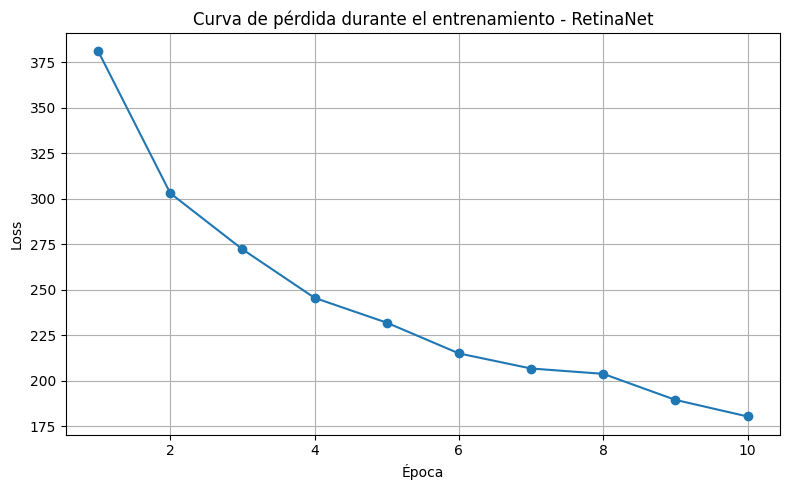

In [ ]:
import matplotlib.pyplot as plt

# Pérdidas por época
losses = [381.2355, 303.1587, 272.3483, 245.6615, 232.0336, 215.1497, 206.8556, 203.9247, 189.6175, 180.5120]
epochs = list(range(1, len(losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o')
plt.title("Curva de pérdida durante el entrenamiento - RetinaNet")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


### Segundo modelo RetinaNET


 Se aplicaron mejoras concretas para optimizar su rendimiento sobre el dataset TACO. Se realizó fine-tuning del backbone ResNet50, permitiendo que el modelo ajuste también las capas convolucionales y no solo la cabeza de clasificación. Además, se incrementó la cantidad de épocas de entrenamiento de 10 a 25, y se incorporó un scheduler de learning rate (ReduceLROnPlateau) que reduce automáticamente la tasa de aprendizaje cuando la pérdida se estanca. Estas modificaciones apuntan a una mejor convergencia del modelo, mayor capacidad de adaptación al dominio específico y mejores métricas de detección, como mAP, precisión y recall.

In [ ]:
from torchvision import transforms

transform_tensor = transforms.ToTensor()

train_dataset_v2 = TacoRetinaDataset(train_df, image_map, class_to_id, transform=transform_tensor)
val_dataset_v2 = TacoRetinaDataset(val_df, image_map, class_to_id, transform=transform_tensor)

train_loader_v2 = DataLoader(train_dataset_v2, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader_v2 = DataLoader(val_dataset_v2, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
%%script echo skipping

from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

model_v2 = retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)

# Descongelar el backbone (fine-tuning)
for param in model_v2.backbone.parameters():
    param.requires_grad = True

# Reemplazar cabeza de clasificación
in_features_v2 = model_v2.head.classification_head.conv[0][0].in_channels
num_anchors_v2 = model_v2.head.classification_head.num_anchors
num_classes_v2 = len(final_classes) + 1

model_v2.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features_v2,
    num_anchors=num_anchors_v2,
    num_classes=num_classes_v2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v2.to(device)


In [ ]:
%%script echo skipping

import torch.optim as optim
from tqdm import tqdm

optimizer_v2 = optim.Adam(model_v2.parameters(), lr=1e-4)
scheduler_v2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v2, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs_v2 = 25
train_loss_history_v2 = []

for epoch in range(num_epochs_v2):
    model_v2.train()
    epoch_loss_v2 = 0.0
    print(f"\nEntrenando model_v2 - Epoch {epoch+1}/{num_epochs_v2}")
    pbar = tqdm(train_loader_v2, desc="Entrenando v2", leave=False)

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict_v2 = model_v2(images, targets)
        losses_v2 = sum(loss for loss in loss_dict_v2.values())

        optimizer_v2.zero_grad()
        losses_v2.backward()
        optimizer_v2.step()

        epoch_loss_v2 += losses_v2.item()
        pbar.set_postfix({"Batch Loss": f"{losses_v2.item():.4f}", "Epoch Loss": f"{epoch_loss_v2:.2f}"})

    scheduler_v2.step(epoch_loss_v2)
    train_loss_history_v2.append(epoch_loss_v2)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss_v2:.4f}")


Entrenando model_v2 - Epoch 1/25
Epoch 1 - Loss: 401.6814

Entrenando model_v2 - Epoch 2/25
Epoch 2 - Loss: 344.8603

Entrenando model_v2 - Epoch 3/25
Epoch 3 - Loss: 284.3562

Entrenando model_v2 - Epoch 4/25
Epoch 4 - Loss: 252.8948

Entrenando model_v2 - Epoch 5/25
Epoch 5 - Loss: 234.6337

Entrenando model_v2 - Epoch 6/25
Epoch 6 - Loss: 225.5761

Entrenando model_v2 - Epoch 7/25
Epoch 7 - Loss: 217.0480

In [ ]:
%%script echo skipping

model_save_path_v2 = "/content/drive/MyDrive/retinanet_taco_v2_finetuned.pth"
torch.save(model_v2.state_dict(), model_save_path_v2)
print(f"✅ Modelo v2 guardado en: {model_save_path_v2}")


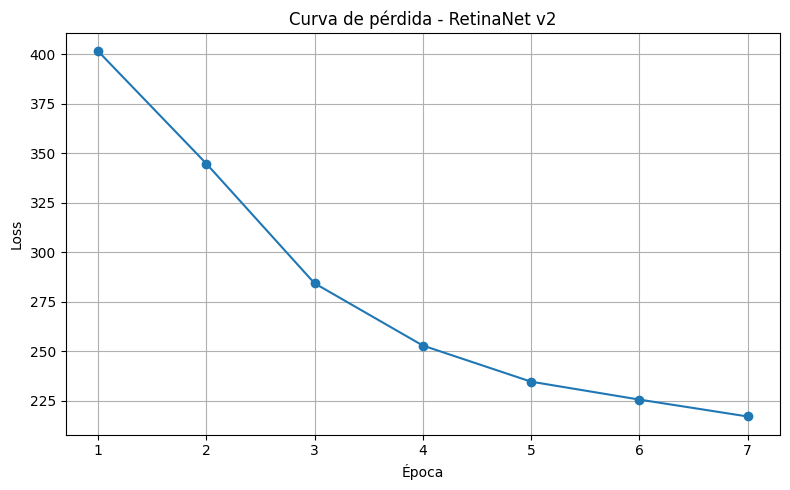

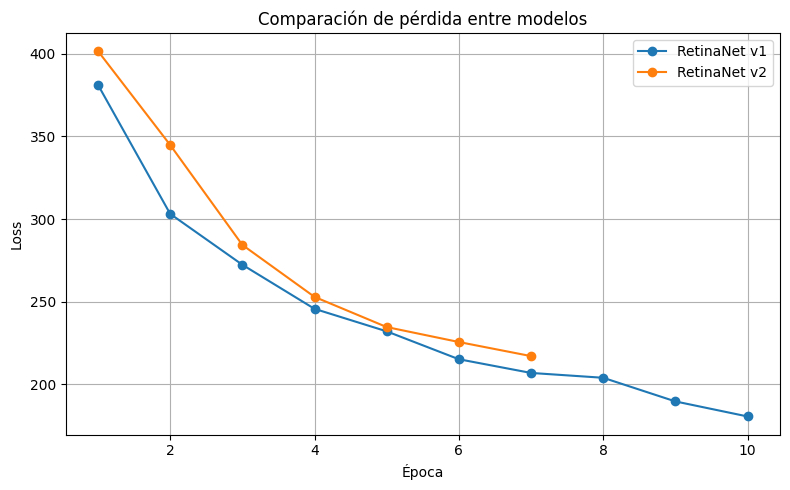

In [ ]:
import matplotlib.pyplot as plt

# Datos del primer modelo (10 épocas)
losses_v1 = [381.2355, 303.1587, 272.3483, 245.6615, 232.0336, 215.1497, 206.8556, 203.9247, 189.6175, 180.5120]
epochs_v1 = list(range(1, len(losses_v1) + 1))

# Datos del segundo modelo (7 épocas)
losses_v2 = [401.6814, 344.8603, 284.3562, 252.8948, 234.6337, 225.5761, 217.0480]
epochs_v2 = list(range(1, len(losses_v2) + 1))

# Gráfico 1: Solo segundo modelo
plt.figure(figsize=(8, 5))
plt.plot(epochs_v2, losses_v2, marker='o', label="RetinaNet v2")
plt.title("Curva de pérdida - RetinaNet v2")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Comparación de ambos modelos
plt.figure(figsize=(8, 5))
plt.plot(epochs_v1, losses_v1, marker='o', label="RetinaNet v1")
plt.plot(epochs_v2, losses_v2, marker='o', label="RetinaNet v2")
plt.title("Comparación de pérdida entre modelos")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Teniendo en cuenta las curvas de pérdida obtenidas durante el entrenamiento, se observa que el modelo v1 presenta una mejor convergencia en comparación con el modelo v2. A pesar de haber sido entrenado durante menos épocas, el modelo v1 alcanza una pérdida considerablemente menor. Además, el modelo v2 requiere mayor tiempo de entrenamiento por época, lo cual no se justifica dado su rendimiento inferior en esta etapa.
Por lo tanto, se decidió continuar el entrenamiento del modelo v1 extendiendo la cantidad de épocas, con el objetivo de seguir mejorando su desempeño sin incurrir en costos computacionales innecesarios.

### Se entrena nuevamente el modelo 1
Este modelo se va guardando por epochs y despues se lo puede volver a entrenar desde la epoch que quedo


In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights

# Cargar modelo con pesos preentrenados
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model = retinanet_resnet50_fpn(weights=weights)

# Definir cantidad de clases (agregando background)
num_classes = len(final_classes) + 1
in_features = model.head.classification_head.conv[0][0].in_channels
num_anchors = model.head.classification_head.num_anchors

# Reemplazar la cabeza del modelo con la cantidad correcta de clases
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
)


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 94.4MB/s]


In [ ]:
import torch.optim as optim

checkpoint_dir = "/content/drive/MyDrive/checkpoints_retinanet"
os.makedirs(checkpoint_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")




    # Dentro del bucle de entrenamiento, reemplazá esto:
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, os.path.join(checkpoint_dir, f"retinanet_checkpoint_epoch_{epoch+1}.pth"))



Epoch 1/10 - Loss: 364.7421
Epoch 2/10 - Loss: 292.7140
Epoch 3/10 - Loss: 257.2739
Epoch 4/10 - Loss: 253.0359
Epoch 5/10 - Loss: 231.5995
Epoch 6/10 - Loss: 225.1610
Epoch 7/10 - Loss: 213.8114


In [ ]:
# Ruta donde guardar en tu Google Drive
full_model_path = "/content/drive/MyDrive/retinanet_taco.pth"

# Guardar el estado del modelo
torch.save(model.state_dict(), full_model_path)
print(f"✅ Modelo guardado en: {full_model_path}")

In [ ]:
import torch
import torch.optim as optim

# Cargar el checkpoint guardado
checkpoint = torch.load("retinanet_checkpoint_epoch_10.pth")

# Cargar modelo y optimizador
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Continuar desde la última época
start_epoch = checkpoint['epoch']
additional_epochs = 10  # Cuántas épocas más querés entrenar

for epoch in range(start_epoch, start_epoch + additional_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}")

    # Guardar nuevo checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, f"retinanet_checkpoint_epoch_{epoch+1}.pth")


In [ ]:
# Ruta donde guardar en tu Google Drive
full_model_path = "/content/drive/MyDrive/retinanet_taco2.pth"

# Guardar el estado del modelo
torch.save(model.state_dict(), full_model_path)
print(f"✅ Modelo guardado en: {full_model_path}")